## Cart-pole en tabulaire

On vous propose pour finir d'utiliser votre code et de tester l'apprentissage sur le problème du cart-pole. A priori, c'est un problème où les états sont des variables continues. On vous propose ici de discrétiser les variables et d'essayer d'utiliser une des méthodes pour voir vos résultats. 

La récompense que vous obtenez est le nombre de pas de temps où le baton est resté en équilibre. Si vous utilisez colab pour coder, vous ne pourrez malheureusement pas visualiser un épisode avec la méthode render :-(

Cet environnement Cart-Pole consiste à déplacer un chariot pour faire tenir en équilibre une poutre. Plus précisément:
* Il y a deux actions : gauche et droite (représentées par 0 et 1).
* L'observation reçue (c'est à dire l'état) est un tableau numpy comprenant 4 variables: la position du chariot, la vélocité, l'angle à la verticale et la position du haut de la poutre.
* L'épisode se termine lorsque l'angle de la poutre à la verticale dépasse 12 degrés.
* Les récompenses reçues sont égales à 1 sauf si l'angle dépasse 12 degrés.

On vous donne ci-dessous les fonctions pour réaliser la discrétisation et pour encoder l'état en un entier.


In [ ]:
import random
import gym
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam

import time

In [ ]:
env_CP = gym.make("CartPole-v1")
print("Environnement avec", env_CP.action_space.n, "actions")
print("L'espace des états est lui codé avec une class", env_CP.observation_space,
      " qui représente un espace continu")
print("Les bornes inférieures des intervalles sont:", env_CP.observation_space.low)
print("Les bornes supérieures des intervalles sont:", env_CP.observation_space.high)
env_CP.reset()
nbIt=0
done=False
while not done:
    observation, reward, done, info = env_CP.step(np.random.randint(2))
    nbIt+=1
print("Episode terminé après {} itérations".format(nbIt))
env_CP.close()

Environnement avec 2 actions
L'espace des états est lui codé avec une class Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)  qui représente un espace continu
Les bornes inférieures des intervalles sont: [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
Les bornes supérieures des intervalles sont: [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
Episode terminé après 22 itérations


In [ ]:
env_CP.reset() # la position du chariot, la vélocité, l'angle à la verticale et la position du haut de la poutre.

array([-0.00557714, -0.01837903, -0.04977662, -0.03577293])

In [ ]:
env_CP.action_space # 2 actions [0, 1]

Discrete(2)

In [ ]:
env_CP.step(0) # tuple((états), récompense, GAME_OVER, _)

(array([-0.00594472, -0.21275315, -0.05049208,  0.24079882]), 1.0, False, {})

## Variables

In [ ]:
EPISODES = 1000

## CLASS DQNAGENT

In [ ]:
import gym
import random
import os
import numpy as np
from collections      import deque
from keras.models     import Sequential
from keras.layers     import Dense
from tensorflow.keras.optimizers import Adam

class Agent():
    def __init__(self, state_size, action_size):
        self.weight_backup      = "cartpole_weight.h5"
        self.state_size         = state_size
        self.action_size        = action_size
        self.memory             = deque(maxlen=2000)
        self.learning_rate      = 0.001
        self.gamma              = 0.95
        self.exploration_rate   = 1.0
        self.exploration_min    = 0.01
        self.exploration_decay  = 0.995
        self.brain              = self._build_model()

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))

        if os.path.isfile(self.weight_backup):
            model.load_weights(self.weight_backup)
            self.exploration_rate = self.exploration_min
        return model

    def save_model(self):
            self.brain.save(self.weight_backup)

    def act(self, state):
        if np.random.rand() <= self.exploration_rate:
            return random.randrange(self.action_size)
        act_values = self.brain.predict(state)
        return np.argmax(act_values[0])

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self, sample_batch_size):
        if len(self.memory) < sample_batch_size:
            return
        sample_batch = random.sample(self.memory, sample_batch_size)
        for state, action, reward, next_state, done in sample_batch:
            target = reward
            if not done:
              target = reward + self.gamma * np.amax(self.brain.predict(next_state)[0])
            target_f = self.brain.predict(state)
            target_f[0][action] = target
            self.brain.fit(state, target_f, epochs=1, verbose=0)
        if self.exploration_rate > self.exploration_min:
            self.exploration_rate *= se 


            
class CartPole:
    def __init__(self):
        self.sample_batch_size = 32
        self.episodes          = 1000
        self.env               = gym.make('CartPole-v1')

        self.state_size        = self.env.observation_space.shape[0]
        self.action_size       = self.env.action_space.n
        self.agent             = Agent(self.state_size, self.action_size)

    def run(self):
        reward_plot = []
        try:
            for index_episode in range(self.episodes):
                state = self.env.reset()
                state = np.reshape(state, [1, self.state_size])

                done = False
                index = 0
                while not done:
#                    self.env.render()

                    action = self.agent.act(state)

                    next_state, reward, done, _ = self.env.step(action)
                    next_state = np.reshape(next_state, [1, self.state_size])
                    self.agent.remember(state, action, reward, next_state, done)
                    state = next_state
                    reward_plot.append(reward)
                    index += 1
                print("Episode {}# Score: {}".format(index_episode, index + 1))
                self.agent.replay(self.sample_batch_size)
        finally:
            self.agent.save_model()
        return reward_plot



In [ ]:
if __name__ == "__main__":
    cartpole = CartPole()
    rewards = cartpole.run()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Episode 0# Score: 10
Episode 1# Score: 11
Episode 2# Score: 11
Episode 3# Score: 10
Episode 4# Score: 10
Episode 5# Score: 11
Episode 6# Score: 10
Episode 7# Score: 10
Episode 8# Score: 10
Episode 9# Score: 10
Episode 10# Score: 11
Episode 11# Score: 10
Episode 12# Score: 10
Episode 13# Score: 9
Episode 14# Score: 9
Episode 15# Score: 11
Episode 16# Score: 11
Episode 17# Score: 11
Episode 18# Score: 11
Episode 19# Score: 10
Episode 20# Score: 9
Episode 21# Score: 10
Episode 22# Score: 11
Episode 23# Score: 9
Episode 24# Score: 9
Episode 25# Score: 10
Episode 26# Score: 9
Episode 27# Score: 10
Episode 28# Score: 10
Episode 29# Score: 10
Episode 30# Score: 10
Episode 31# Score: 11
Episode 32# Score: 11
Episode 33# Score: 11
Episode 34# Score: 10
Episode 35# Score: 12
Episode 36# Score: 11
Episode 37# Score: 10
Episode 38# Score: 10
Episode 39# Score: 11
Episode 40# Score: 9
Episode 41# Score: 9
Episode 42# Score: 11
Episode 43# Score: 11
Episode 44# Score: 11
Episode 45# Score: 11
Episod

Après 1000 itérations, l'agent semble atteindre de très bon score. A faire tester sur jupyter pour utiliser le render.  

In [ ]:
def plot_res(values, title=''):   
    ''' Plot the reward curve and histogram of results over time.'''
    # Update the window after each episode
    clear_output(wait=True)
    
    # Define the figure
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    f.suptitle(title)
    ax[0].plot(values, label='score per run')
    ax[0].axhline(195, c='red',ls='--', label='goal')
    ax[0].set_xlabel('Episodes')
    ax[0].set_ylabel('Reward')
    x = range(len(values))
    ax[0].legend()
    # Calculate the trend
    try:
        z = np.polyfit(x, values, 1)
        p = np.poly1d(z)
        ax[0].plot(x,p(x),"--", label='trend')
    except:
        print('')
    
    # Plot the histogram of results
    ax[1].hist(values[-50:])
    ax[1].axvline(195, c='red', label='goal')
    ax[1].set_xlabel('Scores per Last 50 Episodes')
    ax[1].set_ylabel('Frequency')
    ax[1].legend()
    plt.show()

# Méthode aléatoire

In [ ]:
    # Politique aléatoire pour voir comment CARTPOLE fonctionne

def random_search(env, episodes, 
                  title='Random Strategy'):
    """ Random search strategy implementation."""
    final = []
    for episode in range(episodes):
        state = env.reset()
        done = False
        total = 0
        while not done:
            # Sample random actions
            action = env.action_space.sample()
            # Take action and extract results
            next_state, reward, done, _ = env.step(action)
            # Update reward
            total += reward
            if done:
                break
        # Add to the final reward
        final.append(total)
        plot_res(final,title)
    return final

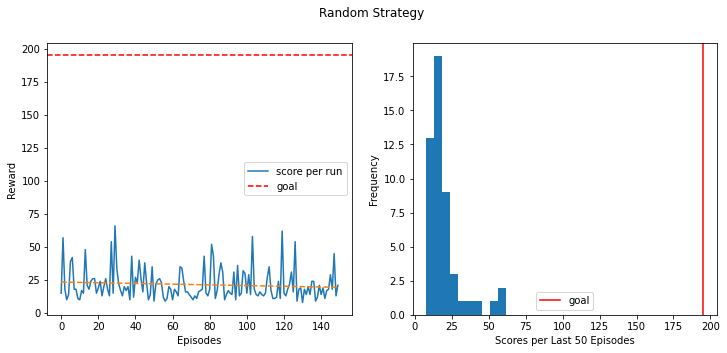

In [ ]:
episodes = 150
final = random_search(env_CP, episodes)